## Задача

В этом соревновании вам предстоит построить модель, которая предсказывает вероятность того, что водитель подаст заявление на автострахование в следующем году. В то время как Порто Сегуро использует машинное обучение в течение последних 20 лет, они ищут сообщество машинного обучения Kaggle для изучения новых, более мощных методов. Более точный прогноз позволит им еще больше адаптировать свои цены и, надеюсь, сделать автострахование более доступным для большего числа водителей.

**Улучшение качества с помощью отбора признаков**

In [1]:
!pip install xgboost
!pip install rfpimp
!pip install catboost
!pip install shap

  Created wheel for rfpimp: filename=rfpimp-1.3.7-cp37-none-any.whl size=10670 sha256=a237fb3792a9102ea3c0497eaecacd3fe23d8773596a51bb3b7f8d0a368258dd
  Stored in directory: /root/.cache/pip/wheels/16/08/23/9d90df482c9c943df4d6fe874c0937f8e81dc3db917c9300c2
Successfully built rfpimp
     |████████████████████████████████| 69.2MB 44kB/s 
     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491614 sha256=f028cbdee1a6da6a7929fadb6b7a28b8ebe27f07f7786e9b608bccf11131824d
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from rfpimp import feature_dependence_matrix, plot_dependence_heatmap, plot_corr_heatmap
from sklearn.model_selection import cross_validate
import shap
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.8f' % x)
pd.set_option('display.max_columns', 60)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
data = pd.read_csv('train.csv')
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.70000000,0.20000000,0.71807033,10,1,-1,0,1,4,1,0,0,1,12,2,0.40000000,0.88367892,0.37080992,3.60555128,0.60000000,0.50000000,0.20000000,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.80000000,0.40000000,0.76607767,11,1,-1,0,-1,11,1,1,2,1,19,3,0.31622777,0.61881652,0.38871583,2.44948974,0.30000000,0.10000000,0.30000000,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.00000000,0.00000000,-1.00000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.31622777,0.64158572,0.34727511,3.31662479,0.50000000,0.70000000,0.10000000,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.90000000,0.20000000,0.58094750,7,1,0,0,1,11,1,1,3,1,104,1,0.37416574,0.54294879,0.29495762,2.00000000,0.60000000,0.90000000,0.10000000,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.70000000,0.60000000,0.84075859,11,1,-1,0,-1,14,1,1,2,1,82,3,0.31606961,0.56583150,0.36510273,2.00000000,0.40000000,0.60000000,0.00000000,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
data.drop('id', axis=1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_

In [6]:
# разбиваем данные на обучающие и тестовые, получаем обучающий массив признаков, тестовый массив признаков
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1),
                                                    data['target'],
                                                    test_size=0.3,
                                                    stratify=data['target'],
                                                    random_state=42)

In [7]:
# Создаем класс LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42, n_estimators=300)  

# задаем сетку гиперпарамметров
param_grid = { 'learning_rate': [0.1, 0.05, 0.01, 0.001]}

# создаем экземпляр класса GridSearchCV, переда контейнер, сетку гиперпараметров,
# указав количество блоков перекрестной проверки, отключив запись метрик
# для обучающих блоков перекрестной проверки в атрибут cv_results
gs = GridSearchCV(lgbm_model,
                  param_grid,
                  scoring='roc_auc',
                  cv=5,
                  return_train_score=False)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=300,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.001]},
             pre_dispatch='

In [8]:
print('Наилучшее значение параметра : {}'.format(gs.best_params_))
print('Наилучшее значение AUC : {:.3f}'.format(gs.best_score_))

Наилучшее значение параметра : {'learning_rate': 0.01}
Наилучшее значение AUC : 0.633


In [9]:
lgbm_model2= LGBMClassifier(random_state=42, n_estimators=300, learning_rate=0.01)

param_grid2 =  {
    'lambda_l1':[0, 10],
    'bagging_fraction': [0.5, 1],
    'feature_fraction': [0.5, 1]
}           

gs2 = GridSearchCV(lgbm_model2,
                  param_grid2,
                  scoring='roc_auc',
                  cv=5,
                  return_train_score=False)

gs2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.01, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=300,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=42, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'bagging_fraction': [0.5, 1],
                         'feature_fracti

In [10]:
print('Наилучшее значение параметра : {}'.format(gs2.best_params_))
print('Наилучшее значение AUC : {:.3f}'.format(gs2.best_score_))

Наилучшее значение параметра : {'bagging_fraction': 0.5, 'feature_fraction': 1, 'lambda_l1': 10}
Наилучшее значение AUC : 0.634


In [12]:
model_all= LGBMClassifier(random_state=42, learning_rate = 0.01, n_estimators=300,
                            bagging_fraction=0.5, feature_frection=1, lambda_l1=10,
                            importance_type='gain')  

# выполним перекрестную проверку
output = cross_validate(model_all,
                        X_train,
                        y_train,
                        cv=5,
                        scoring='roc_auc',
                        return_estimator=True)

# создадим список и сохраном в него важности признаков,
# рассчитанные для каждой модели
fi = []
for estimator in output['estimator']:
  fi.append(estimator.feature_importances_)

# преобразовываем список в датафрейм, индексы в котором будут именами наших переменных  
fi = pd.DataFrame(np.array(fi).T,
                  columns=['importance ' + str(idx) for idx in range(len(fi))],
                  index = X_train.columns)
# найдем средние важности и добавим столбез с ними
fi['mean_importance'] = fi.mean(axis=1)
fi

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
ps_ind_01,3634.11843014,3172.45801353,4035.87575197,3279.06987143,2702.83714104,3364.87184162
ps_ind_02_cat,1180.81135607,1882.19693899,1775.92964697,2375.23713636,2278.47166729,1898.52934914
ps_ind_03,13521.97072601,12791.99010944,11509.53043318,11959.67374229,12108.93555784,12378.42011375
ps_ind_04_cat,1130.56435776,1201.73512697,1314.90494204,904.47342062,798.09325933,1069.95422134
ps_ind_05_cat,16222.12306643,16123.02086258,15932.37066174,16057.97703266,17996.74093056,16466.44651079
ps_ind_06_bin,7848.01708078,7344.12867975,7628.59964228,6914.00448751,8448.97758007,7636.74549408
ps_ind_07_bin,1684.69169283,2116.86437941,1721.08208227,1947.20034266,1518.87499571,1797.74269857
ps_ind_08_bin,797.62602758,294.66852856,602.52638626,445.62016964,395.38190889,507.16460419
ps_ind_09_bin,2757.77236462,2649.19727755,2396.16355896,2329.34756851,3267.23337460,2679.94282885
ps_ind_10_bin,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [22]:
# записываем серию, где индексные метки  - признаки, значения - важности
features = fi['mean_importance']
features = features.sort_values(ascending=True)
features

ps_calc_16_bin       0.00000000
ps_car_10_cat        0.00000000
ps_ind_13_bin        0.00000000
ps_ind_12_bin        0.00000000
ps_ind_10_bin        0.00000000
ps_ind_11_bin        0.00000000
ps_ind_14            4.13852005
ps_calc_18_bin      26.88713598
ps_calc_20_bin      27.24685402
ps_calc_19_bin      29.30425615
ps_calc_15_bin      29.94704609
ps_car_08_cat       40.85762415
ps_calc_17_bin      43.58873396
ps_ind_18_bin       87.11542606
ps_calc_06         287.05552168
ps_calc_07         290.63048229
ps_calc_08         305.89214191
ps_calc_04         316.40283184
ps_calc_13         317.46883774
ps_calc_12         390.33250446
ps_calc_11         397.19356203
ps_car_05_cat      418.74798470
ps_calc_05         471.20317659
ps_calc_09         495.92781897
ps_ind_08_bin      507.16460419
ps_calc_02         532.49589968
ps_car_12          637.38455076
ps_calc_01         648.48987713
ps_calc_03         702.67045021
ps_car_02_cat      713.74446478
ps_car_06_cat      716.96568480
ps_calc_

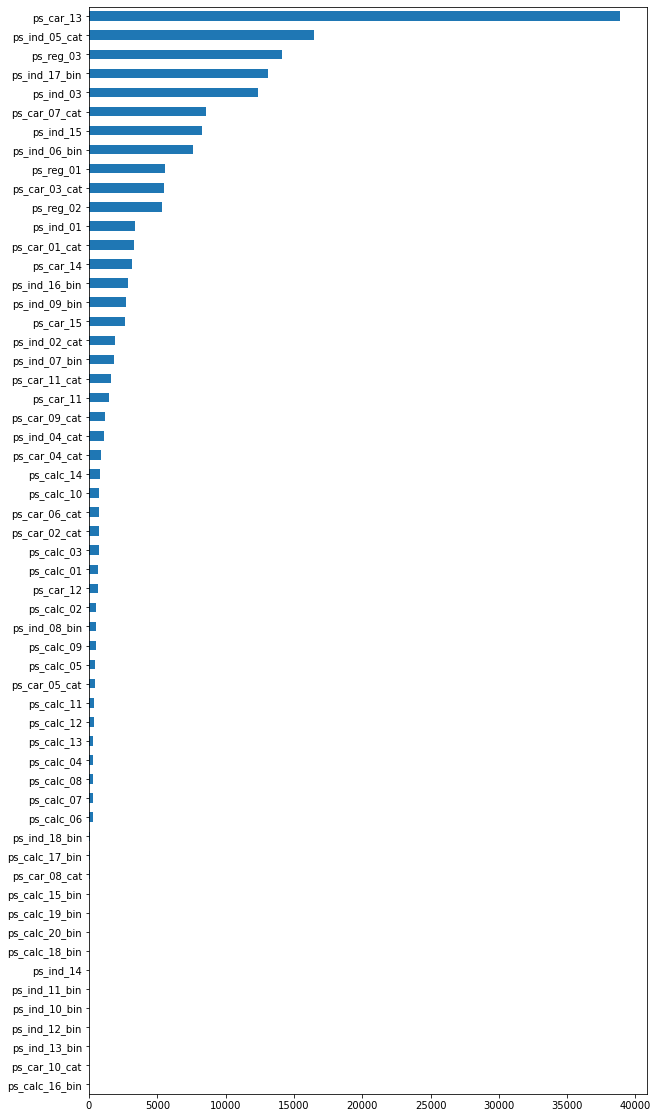

In [16]:
features.plot.barh(figsize=(10,20));

In [25]:
# создаем список признаков
features = list(features.index)
features

['ps_calc_16_bin',
 'ps_car_10_cat',
 'ps_ind_13_bin',
 'ps_ind_12_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_14',
 'ps_calc_18_bin',
 'ps_calc_20_bin',
 'ps_calc_19_bin',
 'ps_calc_15_bin',
 'ps_car_08_cat',
 'ps_calc_17_bin',
 'ps_ind_18_bin',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_04',
 'ps_calc_13',
 'ps_calc_12',
 'ps_calc_11',
 'ps_car_05_cat',
 'ps_calc_05',
 'ps_calc_09',
 'ps_ind_08_bin',
 'ps_calc_02',
 'ps_car_12',
 'ps_calc_01',
 'ps_calc_03',
 'ps_car_02_cat',
 'ps_car_06_cat',
 'ps_calc_10',
 'ps_calc_14',
 'ps_car_04_cat',
 'ps_ind_04_cat',
 'ps_car_09_cat',
 'ps_car_11',
 'ps_car_11_cat',
 'ps_ind_07_bin',
 'ps_ind_02_cat',
 'ps_car_15',
 'ps_ind_09_bin',
 'ps_ind_16_bin',
 'ps_car_14',
 'ps_car_01_cat',
 'ps_ind_01',
 'ps_reg_02',
 'ps_car_03_cat',
 'ps_reg_01',
 'ps_ind_06_bin',
 'ps_ind_15',
 'ps_car_07_cat',
 'ps_ind_03',
 'ps_ind_17_bin',
 'ps_reg_03',
 'ps_ind_05_cat',
 'ps_car_13']

In [26]:
# вычисляем AUC, усредненный по проверочным блокам всех моделей перекрестной проверки
auc_score_all = output['test_score'].mean()
auc_score_all

0.6337963788722549

In [31]:
# жадный отбор признаков на основе отрицительной разницы AUC
# задаем пороговое значение разницы AUC
tol = 0.0001

print('выполнение последовательного удаления признаков')

# список в который будем записывать удаляемые признаки
features_to_remove = []
# список в который будем записывать значения AUC
auc_score_mean_list = []
# список в который будем записывать разницу AUC
diff_auc_list = []

# зададим счетчик для оуенки прогресса
count = 1

# итерируем по всем признакам признаки упорядочены по важности
# - мере возрастания информационного выйграша
for feature in features:
  print()
  print('проверяемый признак: ', feature, ' признак', count, ' из', len(features))
  count = count + 1

  # создаем экземпляр класса
  model_l= LGBMClassifier(random_state=42, learning_rate = 0.01, n_estimators=300,
                            bagging_fraction=0.5, feature_frection=1, lambda_l1=10)  
  # обучаем модели со всеми признаками минус уже удаленные признаки
  # (берем их из списка удаляемых признаков) и оцениваемый признак
  auc_scores = cross_val_score(model_l,
                               X_train.drop(features_to_remove + [feature], axis=1),
                               y_train,
                               scoring = 'roc_auc', 
                               cv=5)
  # вычисляем AUC, усредненный по проверочным блокам всех моделей перекрестной проверки
  auc_score_mean = auc_scores.mean()

  print('AUC модели после удаления ={}'.format((auc_score_mean)))
  # добавляем усредненное значение AUC в список
  auc_score_mean_list.append(auc_score_mean)

  # печатаем AUC модели со всеми признаками
  print('AUC модели со всеми признаками={}'.format((auc_score_all)))

  # определяем разницу AUC, если отрицательное значение - удаление признака улучшило AUC
  diff_auc = auc_score_all - auc_score_mean
  # записываем разницу AUC в список
  diff_auc_list.append(diff_auc)
  
  # сравниваем разницу AUC с порогом, заданным заранее
  # если разница AUC больше или равна порогу, сохраняем
  if diff_auc >= tol:
    print('разница AUC={}'.format(diff_auc))
    print('сохраняем: ', feature)
    print()
  else:
    print('разница AUC={}'.format(diff_auc))
    print('удаляем: ', feature)
    print()

    # если разница AUC меньше порога и мы удаляем признак,
    # мы в качестве нового опорного значения AUC задаем
    # значение AUC для модели с оставшимися признаками
    auc_score_all = auc_score_mean
    
    # добавляем удаляемый признак в список
    features_to_remove.append(feature)

# формируем датафрейм 
df = pd.DataFrame({'feature': features,
                   'auc_score_mean_list': auc_score_mean_list,
                   'diff_auc_list': diff_auc_list})

# цикл завершен, вычисляем количество удаленных признаков
print('ВЫПОЛНЕНО:')
print('общее уоличество признаков для удаления: ', len(features_to_remove))

# определяем признаки, которые мы хотим сохранить(не удаляем)
features_to_keep = [x for x in features if x not in features_to_remove]
print('общее количество признаков для сохранения: ', len(features_to_keep))

выполнение последовательного удаления признаков

проверяемый признак:  ps_calc_16_bin  признак 1  из 57
AUC модели после удаления =0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
разница AUC=0.0
удаляем:  ps_calc_16_bin


проверяемый признак:  ps_car_10_cat  признак 2  из 57
AUC модели после удаления =0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
разница AUC=0.0
удаляем:  ps_car_10_cat


проверяемый признак:  ps_ind_13_bin  признак 3  из 57
AUC модели после удаления =0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
разница AUC=0.0
удаляем:  ps_ind_13_bin


проверяемый признак:  ps_ind_12_bin  признак 4  из 57
AUC модели после удаления =0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
разница AUC=0.0
удаляем:  ps_ind_12_bin


проверяемый признак:  ps_ind_10_bin  признак 5  из 57
AUC модели после удаления =0.6337963788722549
AUC модели со всеми признаками=0.6337963788722549
разница AUC=0.0
удаляем:  ps_in

In [33]:
df.sort_values(by='diff_auc_list', ascending=False)

,feature,auc_score_mean_list,diff_auc_list
55,ps_ind_05_cat,0.62978115,0.00491098
52,ps_ind_03,0.63029787,0.00439426
56,ps_car_13,0.63193996,0.00275216
53,ps_ind_17_bin,0.63213864,0.00255348
50,ps_ind_15,0.63253407,0.00215805
51,ps_car_07_cat,0.63291583,0.00177629
48,ps_reg_01,0.63336871,0.00125154
45,ps_ind_01,0.63378883,0.00083142
44,ps_car_01_cat,0.63392532,0.00069493
47,ps_car_03_cat,0.63395877,0.00066147


In [34]:
# еще один подход - смотрим,как меняются важности признаков по мере увеличения глубины:
# наиболее важные признаки - те, которые начинают использоваться раньше остальных

# задаем значения глубины
max_depth_grid = [1, 2, 3, 4, 5]

# создаем список fi, в который будем сохранять важности признаков и сохраним в него важности, 
# расчитанные для каждой модели
fi = []

# обучаем модели с разными значениями глубины и получаем важности
for max_depth in max_depth_grid:
  model_all_features = LGBMClassifier(random_state=42, learning_rate = 0.01,
                                      n_estimatators=300, bagging_fraction=0.5,
                                      feature_fraction=1, lambda_l1=10,
                                      max_depth=max_depth, importance_type='gain')
  model_all_features.fit(X_train,y_train)
  fi.append(model_all_features.feature_importances_)

# преобразуем список в датафрейм, индексы в котором будут именами наших переменных
fi = pd.DataFrame(np.array(fi).T,
                  columns = ['importance ' + str(idx) for idx in range(len(fi))],
                  index =  X_train.columns)

# вычисляем усредненные важности и добавляем столбец с ними
fi['mean_importance'] = fi.mean(axis=1)
# сортируем по убыванию усредненных важностей
fi =  fi.sort_values(by='mean_importance', ascending=True)
fi

,importance 0,importance 1,importance 2,importance 3,importance 4,mean_importance
ps_car_08_cat,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_calc_18_bin,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_calc_17_bin,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_calc_16_bin,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_calc_15_bin,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_calc_06,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_calc_04,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_car_10_cat,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_calc_19_bin,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
ps_ind_14,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


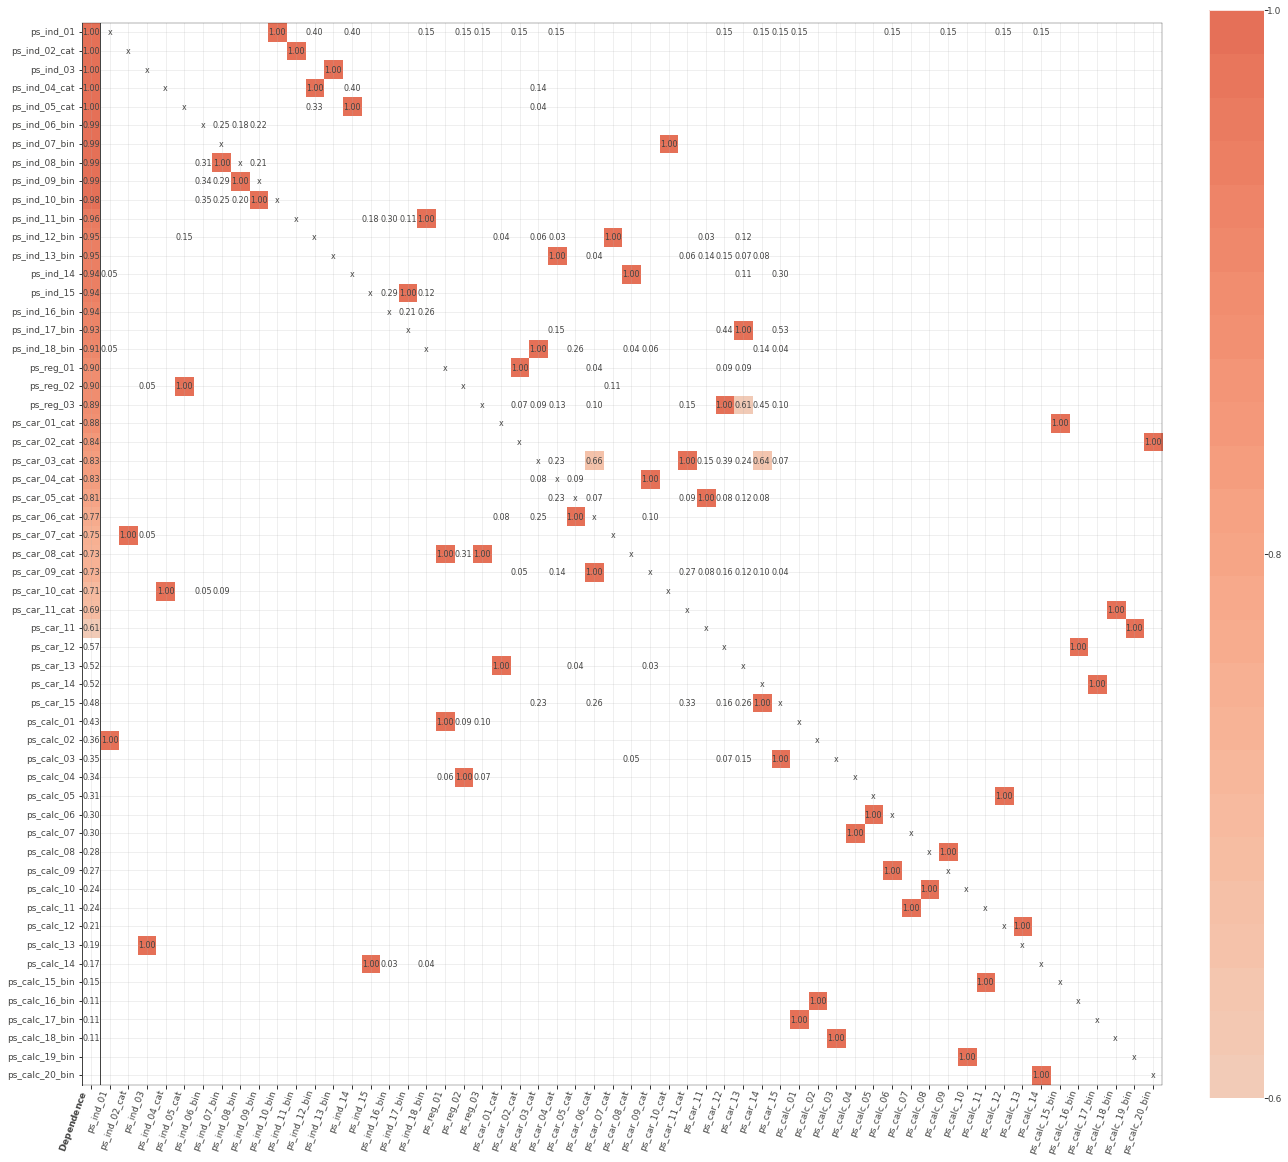

In [35]:
# вычисляем матрицу взаимодействий признаков, значения - это пермутированные важности признаков, 
# с помощью которых мы пытаемся предсказать интересующий признак
D = feature_dependence_matrix(X_train, sort_by_dependence=True)
viz = plot_dependence_heatmap(D, figsize=(18,18))
viz.view()

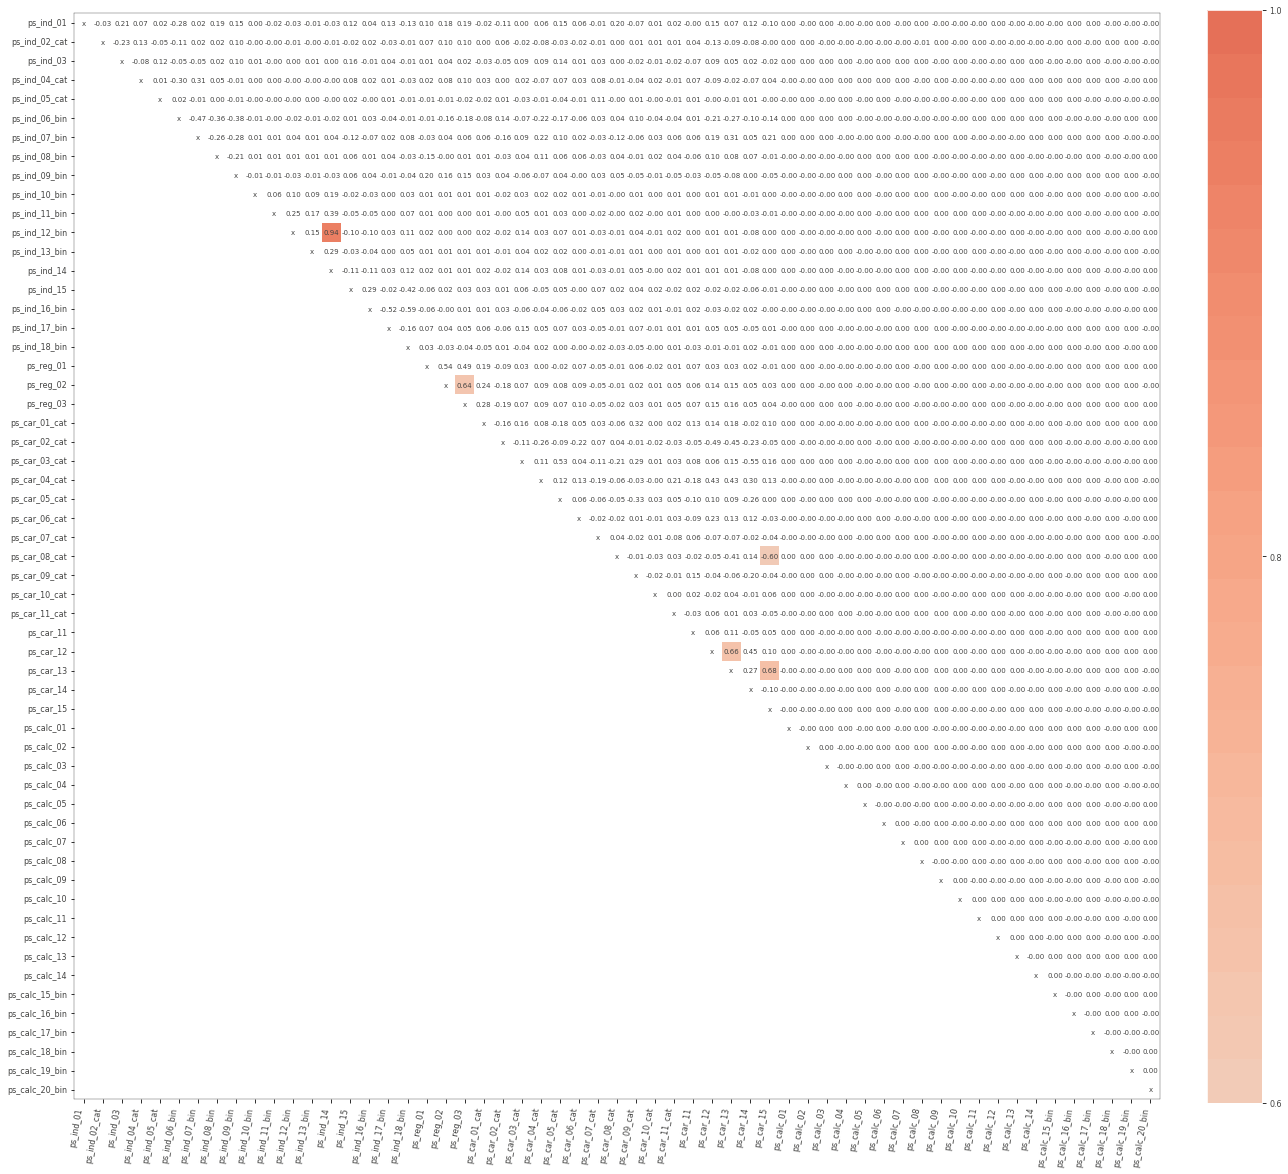

In [36]:
# матрица корреляции Спирмана
viz2 = plot_corr_heatmap(X_train, figsize=(18,18), label_fontsize=8, value_fontsize=7)
viz2.view()

In [54]:
# функция предварительной подготовки
def preprocessing(df, lightgbm=True, newdata=False):
  # удаляем столбцы с calc в названии
  calc_columns = df.columns[df.columns.str.contains('calc')]
  df.drop(calc_columns, axis=1, inplace=True)

  # для новых данных
  if newdata:
    # записываем id набора
    ident = df['id']
    # удаляем id из набора
    df.drop('id', axis=1, inplace=True)
  # для иторических данных  
  else:
    # удаляем id из набора
    df.drop('id', axis=1, inplace=True)
    # формируем массив меток и массив признаков
    labels = df.pop('target')
  # если готовим данные для LightGBM
  if lightgbm:
    # удаляем наименее важные переменные
    some_columns = ['ps_ind_14', 'ps_car_10_cat',
                    'ps_ind_10_bin', 'ps_ind_11_bin',
                    'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_18_bin']

    df.drop(some_columns, axis=1, inplace=True)

    # записываем список столбцов с cat в названии
    cat_columns = df.columns[df.columns.str.contains('cat')]
    # формируем массив с ними
    df_ = df[cat_columns]
    # столбцам с cat в названии присваемаем тип object и выполняем дамми-кодирование
    for col in cat_columns:
      df[col]= df[col].astype('object')
    df=pd.get_dummies(df)
    
    # конкатенируем массив с исходными столбцами с cat в названии и массив, 
    # к которому было применено дамми-кодирование
    df = pd.concat([df_, df], axis=1)

  # готовим данные для CatBoost и XGBoost
  else:     
    # удаляем наименее важные переменные
    some_columns = ['ps_ind_14', 'ps_car_10_cat', 'ps_car_14',
                    'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
                    'ps_ind_13_bin', 'ps_car_11', 'ps_car_12'] 
    df.drop(some_columns, axis=1, inplace=True)

  # для новых данных
  if newdata:
    # возвращаем преобразованный массив признаков , идентификатор
    return df, ident
    # для обучающих данных 
  else:
    # возвращаем преобразованный массив признаков, массив меток
    return df,labels  

In [55]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [39]:
# Выполняем предварительную подготовку данных для LightGBM
train, labels = preprocessing(train, lightgbm=True, newdata=False)
test, ident = preprocessing(test, lightgbm=True, newdata=True)

In [41]:
 # создаем экземпляр класса LGBMClassifier
lightgbm_model = LGBMClassifier(random_state=42, 
                          feature_fraction=0.4,
                          lambda_l1=8,
                          bagging_fraction=0.1,
                          learning_rate=0.012,
                          n_estimator=1600)

In [42]:
# обучаем модель на всем историческом наборе
lightgbm_model.fit(train, labels)

LGBMClassifier(bagging_fraction=0.1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', lambda_l1=8, learning_rate=0.012,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimator=1600, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [44]:
# вычисляем вероятность для набора новых данных
lgbm_preds_prob = lightgbm_model.predict_proba(test)[:, 1]
lgbm_preds_prob

array([0.0285216 , 0.03052764, 0.03415592, ..., 0.0332346 , 0.0313389 ,
       0.03348006])

In [59]:
print('Наилучшее значение AUC : {:.3f}'.format(lightgbm_model.best_score_))

TypeError: ignored

In [56]:
# Выполняем предварительную подготовку данных для CatBoost XGBoost
train, labels = preprocessing(train, lightgbm=False, newdata=False)
test, ident = preprocessing(test, lightgbm=False, newdata=True)

In [57]:
# формируем массив индексов категориальных признаков
cat_feature_ids = np.where(train.dtypes != np.float)[0]

#формируем обучающий пул
train_pool = Pool(train, labels, cat_features=cat_feature_ids)

# создаем экземпляр класса CatBoostClassifier
catbst_model = CatBoostClassifier(iterations=1200,
                                  learning_rate=0.1,
                                  random_strength=0.15,
                                  simple_ctr='Counter:CtrBorderCount=50',
                                  model_size_reg=0.1,
                                  max_depth=4,
                                  random_seed=0,
                                  logging_level='Silent')

In [58]:
# обучаем модель 
catbst_model.fit(train_pool)

Change of simpleCtr will not affect combinations ctrs.
Change of simpleCtr will not affect combinations ctrs.


In [60]:
# вычисляем вероятность для набора новых данных
catbst_preds_prob = catbst_model.predict_proba(test)[:, 1]

In [61]:
# создаем экземпляр класса XGBClassifier
xgbst_model = XGBClassifier(learning_rate=0.04,
                            subsample=0.7,
                            random_state=42,
                            max_depth=4,
                            n_estimators=500)

# обучаем модель на всем историческом наборе
xgbst_model.fit(train, labels)

# вычисляем вероятность для набора новых данных
xgbst_preds_prob = xgbst_model.predict_proba(test)[:, 1]

In [63]:
# усредняем вероятности с весами , учитывающими качество модели
average_prob = (catbst_preds_prob * 0.5 + xgbst_preds_prob * 0.3 + lgbm_preds_prob * 1 )/3

In [65]:
print(average_prob)

[0.01687765 0.01700931 0.01810186 ... 0.02128726 0.01652995 0.01942152]


In [66]:
pd.DataFrame({'id': ident, 'target': average_prob}).to_csv('porto_seguro.csv', index=False)